In [31]:
#机器学习包
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ShuffleSplit
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR 
from sklearn.neighbors import KNeighborsRegressor


import time

#神经网络包
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,TensorDataset,DataLoader
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import random, os

In [32]:
#保证数据可复现
#设置全局随机种子，以确保代码运行时的随机性得到控制，从而保证数据可复现性
def random_seed(seed):
      # 控制 Python 内置的随机数生成器
    random.seed(seed)

    # 控制 Python 内部的哈希函数随机化，以确保字符串的哈希值是可复现的
    os.environ['PYTHONHASHSEED'] = str(seed)

    # 控制 NumPy 的随机数生成器
    np.random.seed(seed)

    # 控制 PyTorch 的 CPU 随机数生成器
    torch.manual_seed(seed)

    # 控制 PyTorch 在使用单个 GPU 时的随机性
    torch.cuda.manual_seed(seed)

    # 控制 PyTorch 在使用多个 GPU 时的随机性
    torch.cuda.manual_seed_all(seed)

    # 确保 PyTorch 的计算是确定性的，禁用某些非确定性算法
    torch.backends.cudnn.deterministic = True


#自定义函数
#定义函数
#标准化数据
#这个函数用于对特征数据进行标准化处理
#（即将数据转换为均值为 0、方差为 1 的标准正态分布），并返回标准化后的数据和标签的组合。
def ss(features, labels):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()   # 使用标准化工具
    X_s = scaler.fit_transform(features)  # 对特征进行标准化
    X_s = pd.DataFrame(X_s)  # 转换为 DataFrame
    data = pd.concat([X_s, labels], axis=1)  # 将标准化后的特征与标签拼接
    return data

#评估模型得分
#这个函数使用交叉验证来评估模型的 RMSE、MAE 和 R² 得分，并将结果返回为一个包含评分的 DataFrame。
def model_score(model, x, y, trainsize, testsize):
    cv = ShuffleSplit(n_splits=10, train_size=trainsize, test_size=testsize, random_state=0)
    rmse = cross_val_score(model, x, y, scoring="neg_mean_squared_error", cv=cv)
    rmse_score = np.sqrt(-rmse)
    rmse_mean = rmse_score.mean()
#     rmse_std = rmse_score.std(ddof=1)

    mae = cross_val_score(model, x, y, scoring="neg_mean_absolute_error", cv=cv)
    mae_score = -mae
    mae_mean = mae_score.mean()
#     mae_std = mae_score.std(ddof=1)

    r2 = cross_val_score(model, x, y, scoring='r2', cv=cv)
    r2_mean = r2.mean()
#     r2_std = r2.std(ddof=1)  # 无偏估计

    scores = [rmse_score, rmse_mean, mae_score, mae_mean, r2, r2_mean]
# 将每个评分结果转为 DataFrame
    rmse = pd.DataFrame(scores[0], columns=['rmse'], index = [np.arange(len(scores[0]))])
    mae = pd.DataFrame(scores[2], columns=['mae'], index = [np.arange(len(scores[2]))])
    R2 = pd.DataFrame(scores[4], columns=['R2'], index = [np.arange(len(scores[4]))])
    scores_df = pd.concat([rmse,mae,R2], axis=1)
    return scores_df


#导出预测值到csv
#此函数将真实值和预测值写入到 CSV 文件中。
def ToCsv(model, Xtest, ytest, filename):
    ytest = pd.DataFrame(ytest.values, index=[np.arange(len(ytest))], columns=['yreal1', 'yreal2', 'yreal3'])
    ypredict = model.predict(Xtest)
    ypredict = pd.DataFrame(ypredict, index=[np.arange(len(ytest))], columns=['ypredict1', 'ypredict2', 'ypredict3'])
    # ypredict
    # 合并真实值和预测值
    output = pd.concat([ytest, ypredict], axis=1)
    output.to_csv(filename)

#数据导入＋预处理
#此函数从 CSV 文件读取数据，并对其进行标准化处理，最后返回特征和标签
def DataProcess(path):
    data = pd.read_csv(path)
    data_df = pd.DataFrame(data)
    # 提取特征和标签
    X_df = data_df.iloc[:,1:6]
    y_df = data_df.iloc[:,6:9]
    # 标准化处理
    data_s = ss(X_df,y_df)
    X = data_s.iloc[:,0:5]
    y = data_s.iloc[:,5:]
    return X, y

#数据集拆分
#此函数将特征和标签数据集进行训练集和测试集的划分，并使用固定的随机种子来保证可复现性。
def DataSplit(X,y, testsize, seed):
    random_seed(seed)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=testsize)
    return Xtrain, Xtest, ytrain, ytest
#DNN模型、函数

#神经网络数据处理三步：
#1.加载数据，提取出feature和label，并转换成tensor
#2.传入TensorDataset中，实例化TensorDataset为datsset
#3.再将dataset传入到Dataloader中，最后通过enumerate输出我们想要的经过shuffle的bachsize大小的feature和label数据
'''数据预处理'''
#dataframe转换为tensor
#将DataFrame数据转换为PyTorch张量。
def Df2Tensor(df):
    array = np.array(df)
    tensor = torch.tensor(array, dtype=torch.float32)
    return tensor
#将张量打包成TensorDataset，供模型使用。
def ToDataset(*args):
    return TensorDataset(*args)

#dataset变迭代器
#将数据集转为可迭代的DataLoader，方便进行批量训练。
def ToDataLoader(dataset, batchsize):
    return DataLoader(dataset, batchsize, shuffle=True)


'''定义网络结构'''
#Net类定义了一个拥有四层隐藏层的神经网络，并在每一层之间应用了Dropout正则化。ReLU函数用于激活。
#nn.Linear（全连接层）、激活函数如ReLU、Sigmoid，以及正则化层如Dropout
class Net(nn.Module):
    def __init__(self, 
            input_dim, output_dim, 
            hidden_layer1, hidden_layer2, hidden_layer3, hidden_layer4, 
            dropout1, dropout2, dropout3, dropout4):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(input_dim,hidden_layer1)
        self.layer2 = nn.Linear(hidden_layer1,hidden_layer2)
        self.layer3 = nn.Linear(hidden_layer2,hidden_layer3)
        self.layer4 = nn.Linear(hidden_layer3,hidden_layer4)
        self.layer5 = nn.Linear(hidden_layer4,output_dim)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)
        self.dropout3 = nn.Dropout(dropout3)
        self.dropout4 = nn.Dropout(dropout4)

        # self.relu = nn.ReLU()
#前向传播：输入数据经过模型进行前向计算，输出预测值。
    def forward(self, x):
        x = self.layer1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.layer2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.layer3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        x = self.layer4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        x = self.layer5(x)
        return x

def compute_feature_importance(model, X, y, num_repeats=10):
    model.eval()
    baseline = mean_squared_error(y, model(Df2Tensor(X)).detach().numpy())
    importances = []

    for i in range(X.shape[1]):
        feature_importance = []
        for _ in range(num_repeats):
            X_permuted = X.copy()
            np.random.shuffle(X_permuted.iloc[:, i].values)  # 打乱特征列
            permuted_score = mean_squared_error(y, model(Df2Tensor(X_permuted)).detach().numpy())
            importance = baseline - permuted_score
            feature_importance.append(importance)

        importances.append(np.mean(feature_importance))  # 计算平均重要性

    # 绝对值归一化
    absolute_importances = [abs(score) for score in importances]  # 取绝对值
    max_importance = max(absolute_importances)
    min_importance = min(absolute_importances)
    
    if max_importance != min_importance:
        normalized_importances = [(score - min_importance) / (max_importance - min_importance) for score in absolute_importances]
    else:
        normalized_importances = [0 for _ in absolute_importances]  # 如果所有重要性相同，返回全0

    return normalized_importances





'''训练与评估'''
 #定义模型评估参数
 #Metrics类：定义了常见的评估指标，包括rmse（均方根误差）、mae（平均绝对误差）和r2（R²决定系数）
class Metrics():
    def __init__(self, net, dataloader):
        dataset = dataloader.dataset
        self.features = dataset[:][0]
        self.labels = dataset[:][1]
        self.y_hat = torch.clamp(net(self.features), 1, float('inf'))
    def rmse(self):
        return torch.sqrt(F.mse_loss(self.y_hat, self.labels))
    def mae(self):
        return F.l1_loss(self.y_hat, self.labels)
    def smooth_mae(self):
        return F.smooth_l1_loss(self.y_hat, self.labels)
    def r2(self):
        # return r2_score(self.labels.detach().numpy(), self.y_hat.detach().numpy()) 
        SS_res = torch.sum(torch.square(self.labels-self.y_hat))
        SS_tot = torch.sum(torch.square(self.labels - torch.mean(self.labels)))
        r2 = 1 - SS_res / SS_tot
        return r2 

# #初始化权重
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

#数据集特征与标签合并
def DataConcat(Xtrain, Xtest, ytrain, ytest):
    train_df = [Xtrain, ytrain]
    test_df = [Xtest, ytest]
    train_data = pd.concat(train_df,axis=1)
    test_data = pd.concat(test_df,axis=1)
    return train_data, test_data

#定义训练函数,用Adam优化器训练
from torch.optim.lr_scheduler import StepLR

#train：使用Adam优化器训练模型，并引入了学习率调度器StepLR，控制学习率逐渐衰减

#前向传播：输入数据经过模型进行前向计算，输出预测值。
#计算损失：将预测值与真实标签计算损失值。
#反向传播：通过loss.backward()计算梯度。
#优化更新：调用optimizer.step()更新模型参数，之后用optimizer.zero_grad()清空梯度。
#重复以上步骤：遍历整个数据集若干次（称为epoch），逐步优化模型。
def train(net, dataloader, loss, num_epochs, lr, wd):
    net.train()
    
    #train_data[:][0]可以获取train_data中的特征，[1]获取标签

    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(), lr = lr, weight_decay = wd)
    #每隔一个step_size,学习率乘以gamma
    scheduler = StepLR(optimizer, step_size=num_epochs/3, gamma=0.3)
#遍历整个数据集若干次（称为epoch)
    for epoch in range(num_epochs):
        for X, y in dataloader:
            optimizer.zero_grad()
            
            l = loss(net(X), y) 
            l.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            # with torch.no_grad():
            #     print(l)

#模型评估
#NetEval：在每个epoch训练后评估模型性能，并保存不同指标的表现
def NetEval(net, dataloader, num_epochs, loss, lr, wd):
    # 模型评估指标矩阵
    eval_list = []
    rmse, mae, r2 = [], [], []
    # 模型训练过程
    for epochs in range(num_epochs):
        net.train()
        train(net, dataloader, loss, num_epochs, lr, wd)

        net.eval()
        test_metrics = Metrics(net, dataloader)


        rmse.append(test_metrics.rmse().detach().item())
        mae.append(test_metrics.mae().detach().item())
        r2.append(test_metrics.r2().detach().item())
    return r2, mae, rmse

In [33]:
#定义超参数与网络
input_dim, output_dim, hidden_layer1, hidden_layer2, hidden_layer3, hidden_layer4 = 5, 3, 120,60,30,15
# num_epochs, lr, weight_decay, batch_size = 3000, 0.01, 0.002, 54
num_epochs, lr, wd, batch_size = 1000, 0.003, 0, 54
dropout1, dropout2, dropout3, dropout4 = 0,0.01,0.01,0.01

loss = nn.MSELoss()

net = Net(input_dim, output_dim, 
            hidden_layer1, hidden_layer2, hidden_layer3, hidden_layer4,
            dropout1, dropout2, dropout3, dropout4)
net.apply(init_weights)

Net(
  (layer1): Linear(in_features=5, out_features=120, bias=True)
  (layer2): Linear(in_features=120, out_features=60, bias=True)
  (layer3): Linear(in_features=60, out_features=30, bias=True)
  (layer4): Linear(in_features=30, out_features=15, bias=True)
  (layer5): Linear(in_features=15, out_features=3, bias=True)
  (dropout1): Dropout(p=0, inplace=False)
  (dropout2): Dropout(p=0.01, inplace=False)
  (dropout3): Dropout(p=0.01, inplace=False)
  (dropout4): Dropout(p=0.01, inplace=False)
)

In [34]:
#导入解析法数据
AM_Path = 'AM_data.csv'
seed = 0
trainsize1, testsize1 = 0.99,0.01
X, y = DataProcess(AM_Path)
Xtrain1, Xtest1, ytrain1, ytest1 = DataSplit(X,y, testsize1, seed)

#数据预处理
# Xtrain, Xtest, ytrain, ytest
#将tensor转化为dataset对象
train_dataset1 = ToDataset(Df2Tensor(Xtrain1), Df2Tensor(ytrain1))
test_dataset1 = ToDataset(Df2Tensor(Xtest1), Df2Tensor(ytest1))

batchsize = 54
train_dataloader1 = ToDataLoader(train_dataset1, batchsize)
test_dataloader1= ToDataLoader(test_dataset1, batchsize)


#解析法数据训练网络
train(net, train_dataloader1, loss, num_epochs, lr, wd)

# # 计算特征重要性
# importance_scores = compute_feature_importance(net, Xtrain1, ytrain1)
# # 输出特征重要性
# for idx, score in enumerate(importance_scores):
#     print(f'特征 {idx + 1} 的重要性得分: {score}')
   

# for i,d in enumerate(train_dataloader):
#     X,y = d
#     print(y)

每个特征的取值情况：
特征 '0' 的取值: [-1.8458759613029605, -0.1419904585617657, 0.2839809171235327, 0.7099522928088311, 0.9939332099323638], 取值种类数: 5
特征 '1' 的取值: [-1.3416407864998736, -0.44721359549995826, 0.44721359549995726, 1.3416407864998736], 取值种类数: 4
特征 '2' 的取值: [-1.3416407864998736, -0.44721359549995776, 0.44721359549995826, 1.3416407864998736], 取值种类数: 4
特征 '3' 的取值: [-1.224744871391589, 0.0, 1.224744871391589], 取值种类数: 3
特征 '4' 的取值: [-1.4638501094227996, -0.8783100656536793, -0.2927700218845602, 0.2927700218845602, 0.8783100656536805, 1.4638501094227996], 取值种类数: 6

第 1/10 次敏感性分析运行中...

第 2/10 次敏感性分析运行中...

第 3/10 次敏感性分析运行中...

第 4/10 次敏感性分析运行中...

第 5/10 次敏感性分析运行中...

第 6/10 次敏感性分析运行中...

第 7/10 次敏感性分析运行中...

第 8/10 次敏感性分析运行中...

第 9/10 次敏感性分析运行中...

第 10/10 次敏感性分析运行中...


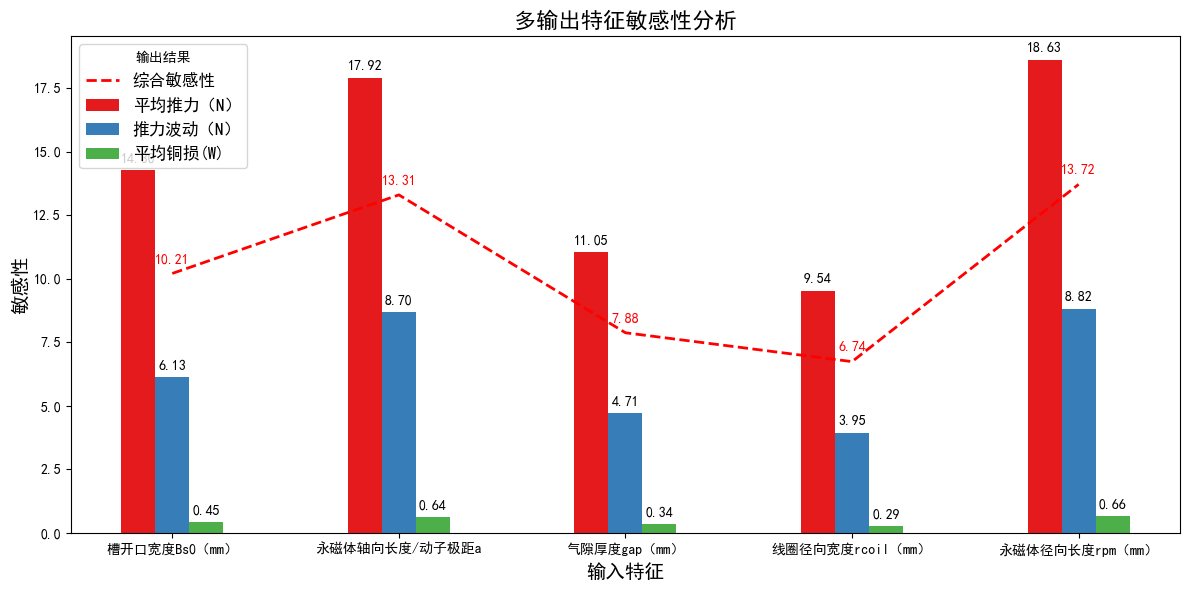


特征敏感性分析结果：
输入特征                           -> 输出结果           敏感性值        
------------------------------------------------------------
槽开口宽度Bs0（mm）                   -> 平均推力（N）         14.3001
槽开口宽度Bs0（mm）                   -> 推力波动（N）         6.1292
槽开口宽度Bs0（mm）                   -> 平均铜损(W)         0.4479
槽开口宽度Bs0（mm）                   -> 综合敏感性           6.9591
------------------------------------------------------------
永磁体轴向长度/动子极距a                  -> 平均推力（N）         17.9171
永磁体轴向长度/动子极距a                  -> 推力波动（N）         8.6971
永磁体轴向长度/动子极距a                  -> 平均铜损(W)         0.6422
永磁体轴向长度/动子极距a                  -> 综合敏感性           9.0854
------------------------------------------------------------
气隙厚度gap（mm）                    -> 平均推力（N）         11.0472
气隙厚度gap（mm）                    -> 推力波动（N）         4.7135
气隙厚度gap（mm）                    -> 平均铜损(W)         0.3374
气隙厚度gap（mm）                    -> 综合敏感性           5.3660
--------------------------------------------------------

In [35]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 数据集预处理和样本选择
Path = "FEM_data.csv"
seed = 0
batchsize = 54

# 加载数据
X1, y = DataProcess(Path)

# 划分数据集
trainsizex, testsizex = 0.25, 0.75

Xtrain, Xtest, ytrain, ytest = DataSplit(X1, y, testsizex, seed)

# 检测每个特征的取值情况
def detect_discrete_values(X1):
    print("每个特征的取值情况：")
    discrete_values = []  # 存储每个特征的取值列表
    for feature in X1.columns:
        unique_values = sorted(X1[feature].unique())  # 获取特征的唯一取值
        discrete_values.append(unique_values)  # 存储每个特征的取值
        print(f"特征 '{feature}' 的取值: {unique_values}, 取值种类数: {len(unique_values)}")
    return discrete_values

# 定义离散值敏感性分析函数
def sensitivity_analysis_discrete(net, X1, discrete_values, num_iterations=10):
    net.eval()  # 设置为评估模式
    Xtrain_tensor = torch.tensor(X1.values, dtype=torch.float32)  # 转为 PyTorch 张量

    # 获取原始模型的输出
    with torch.no_grad():
        original_output = net(Xtrain_tensor).numpy()

    num_outputs = original_output.shape[1]  # 输出维度
    num_features = X1.shape[1]  # 输入特征数量
    avg_sensitivities = np.zeros((num_features, num_outputs))  # 初始化敏感性矩阵

    # 多次运行敏感性分析，取平均值
    for iteration in range(num_iterations):
        print(f"\n第 {iteration + 1}/{num_iterations} 次敏感性分析运行中...")
        sensitivities = np.zeros((num_features, num_outputs))

        for i in range(num_features):
            unique_values = discrete_values[i]
            current_value = Xtrain_tensor[:, i]

            total_sensitivity = np.zeros(num_outputs)
            count = 0

            for value in unique_values:
                if value != current_value[0].item():
                    X_perturb = Xtrain_tensor.clone()
                    X_perturb[:, i] = value

                    with torch.no_grad():
                        perturbed_output = net(X_perturb).numpy()

                    for j in range(num_outputs):
                        sensitivity = np.mean(np.abs(perturbed_output[:, j] - original_output[:, j]))
                        total_sensitivity[j] += sensitivity
                    count += 1

            sensitivities[i] = total_sensitivity / count if count > 0 else total_sensitivity

        avg_sensitivities += sensitivities

    avg_sensitivities /= num_iterations  # 取平均值
    return avg_sensitivities

# 敏感性结果可视化
def plot_sensitivity_single_chart(sensitivities, feature_names, output_labels):
    num_features = sensitivities.shape[0]
    num_outputs = sensitivities.shape[1]

    overall_sensitivities = np.mean(sensitivities[:, :2], axis=1)

    colors = sns.color_palette("Set1", num_outputs)
    plt.figure(figsize=(12, 6))
    bar_width = 0.15

    for j in range(num_outputs):
        positions = np.arange(num_features) + j * bar_width
        plt.bar(positions, sensitivities[:, j], bar_width, label=output_labels[j], color=colors[j])
        for i in range(num_features):
            plt.text(positions[i], sensitivities[i, j] + 0.3, f'{sensitivities[i, j]:.2f}', ha='center', fontsize=10)

    curve_positions = np.arange(num_features) + (num_outputs - 1) * bar_width / 2
    plt.plot(curve_positions, overall_sensitivities, 'r--', label="综合敏感性", linewidth=2)
    for i in range(num_features):
        plt.text(curve_positions[i], overall_sensitivities[i] + 0.4, f'{overall_sensitivities[i]:.2f}', ha='center', fontsize=10, color='red')

    plt.xticks(np.arange(num_features) + bar_width * (num_outputs - 1) / 2, feature_names, rotation=0)
    plt.xlabel('输入特征', fontsize=14)
    plt.ylabel('敏感性', fontsize=14)
    plt.title('多输出特征敏感性分析', fontsize=16)
    plt.legend(title="输出结果", fontsize=12)
    plt.tight_layout()
    plt.show()

# 获取离散特征的取值
discrete_values = detect_discrete_values(X1)

# 执行敏感性分析并取十次的平均值
sensitivities = sensitivity_analysis_discrete(net, X1, discrete_values, num_iterations=10)

# 定义特征名和输出标签
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
custom_feature_names = ["槽开口宽度Bs0（mm）", "永磁体轴向长度/动子极距a", "气隙厚度gap（mm）", "线圈径向宽度rcoil（mm）", "永磁体径向长度rpm（mm）"]
custom_output_labels = ["平均推力（N）", "推力波动（N）", "平均铜损(W)"]

# 绘制敏感性分析图表
plot_sensitivity_single_chart(sensitivities, custom_feature_names, custom_output_labels)
# 打印每个输入特征对每个输出的敏感性值及其平均值
def print_sensitivity_results(sensitivities, feature_names, output_labels):
    num_features = sensitivities.shape[0]
    num_outputs = sensitivities.shape[1]

    print("\n特征敏感性分析结果：")
    print(f"{'输入特征':<30}{' -> ':<4}{'输出结果':<15}{'敏感性值':<12}")
    print("-" * 60)

    for i in range(num_features):
        for j in range(num_outputs):
            print(f"{feature_names[i]:<30} -> {output_labels[j]:<15} {sensitivities[i, j]:.4f}")
        avg_sensitivity = np.mean(sensitivities[i, :])
        print(f"{feature_names[i]:<30} -> {'综合敏感性':<15} {avg_sensitivity:.4f}")
        print("-" * 60)

# 打印敏感性分析结果
print_sensitivity_results(sensitivities, custom_feature_names, custom_output_labels)


In [36]:
# 数据集预处理
Path = "FEM_data.csv"
seed = 0
batchsize = 54

# 加载数据
X, y = DataProcess(Path)

# 划分数据集
trainsizex, testsizex = 0.2, 0.8
Xtrain, Xtest, ytrain, ytest = DataSplit(X, y, testsizex, seed)

# 打印 X 的列名以确认特征名
print("数据集列名:", X.columns)

# 获取每个特征的取值种类
feature_unique_values = {feature: sorted(X[feature].unique()) for feature in X.columns}

# 手动设置每个特征的取值种类限制
low_importance_category_limits = {
    2: (2, 0),  # 特征 2，限制取 4 种类，波动范围 +/- 0
    3: (2, 0),  # 特征 3，限制取 3 种类，波动范围 +/- 0
}
high_importance_category_limits = {
    0: (4, 0),  # 特征 0，限制取 5 种类，波动范围 +/- 0
    1: (3, 0),  # 特征 1，限制取 4 种类，波动范围 +/- 0
    4: (6, 0),  # 特征 4，限制取 6 种类，波动范围 +/- 0
}

# 根据限制的种类数，随机选择具体的取值
categories_per_feature = {}
for feature, (limit, fluctuation) in {**low_importance_category_limits, **high_importance_category_limits}.items():
    available_values = feature_unique_values[feature]
    # 随机挑选 'limit' 种类的具体取值
    selected_values = np.random.choice(available_values, size=limit, replace=False)
    categories_per_feature[feature] = set(selected_values)

# 打印随机挑选的具体取值
for feature, values in categories_per_feature.items():
    print(f"特征 '{feature}' 随机挑选的具体取值: {sorted(values)}")

# 设定样本选择的总数量
n_samples = int(trainsizex * len(X))  # 设置要选择的样本数量

# 随机打乱数据集索引
random_indices = np.random.permutation(X.index)

# 存储已选择样本的索引
selected_indices = []
categories_per_feature_selected = {feature: set() for feature in categories_per_feature.keys()}

# 遍历随机打乱后的样本，按特征种类限制选择样本
for idx in random_indices:
    row = X.loc[idx]  # 通过随机索引获取样本
    satisfy_conditions = True
    
    # 检查每个特征是否满足随机选择的具体值
    for feature, allowed_values in categories_per_feature.items():
        feature_value = row[feature]
        if feature_value not in allowed_values:
            satisfy_conditions = False
            break

    # 如果所有条件都满足，选择该样本
    if satisfy_conditions:
        selected_indices.append(idx)

    # 如果选择的样本数量达到了 n_samples，停止选择
    if len(selected_indices) >= n_samples:
        break

# 初步选完后，检测是否达到所需样本数量
if len(selected_indices) < n_samples:
    print(f"样本数量不足，仅选择了 {len(selected_indices)} 条样本，开始放宽限制。")

    # 进一步调整取值限制，放宽波动范围
    for feature in categories_per_feature:
        limit, fluctuation = low_importance_category_limits.get(feature, (0, 0))
        categories_per_feature[feature] = set(np.random.choice(feature_unique_values[feature], size=limit+fluctuation+1, replace=False))
        print(f"放宽特征 '{feature}' 的限制: 允许的取值变为 {sorted(categories_per_feature[feature])}")

    # 重新选择样本
    for idx in random_indices:
        # 跳过已经选择过的样本
        if idx in selected_indices:
            continue

        satisfy_conditions = True
        
        # 重新按照放宽后的限制进行选择
        for feature, allowed_values in categories_per_feature.items():
            feature_value = X.loc[idx][feature]
            if feature_value not in allowed_values:
                satisfy_conditions = False
                break

        if satisfy_conditions:
            selected_indices.append(idx)

        # 如果选择的样本数量达到了 n_samples，停止选择
        if len(selected_indices) >= n_samples:
            break

# 打印最终选择结果
print(f"最终选择了 {len(selected_indices)} 条样本。")

# 统计选中样本每个特征的取值种类
print("选中样本每个特征的取值种类：")
for feature in X.columns:
    unique_values = X.iloc[selected_indices][feature].unique()
    print(f"特征 '{feature}' 的取值: {sorted(unique_values)}, 取值种类数: {len(unique_values)}")

# 确保所有索引在有效范围内，并将选中的样本作为训练集，剩余数据作为测试集
if selected_indices:
    Xtrain_selected = X.iloc[selected_indices]
    ytrain_selected = y.iloc[selected_indices]

    # 将未选中的样本作为测试集
    Xtest_selected = X.drop(selected_indices)
    ytest_selected = y.drop(selected_indices)

    # 将输入特征和输出值合并到同一个 DataFrame
    train_combined = pd.concat([Xtrain_selected, pd.DataFrame(ytrain_selected)], axis=1)
    test_combined = pd.concat([Xtest_selected, pd.DataFrame(ytest_selected)], axis=1)

    # 将选中的样本和剩下的样本合并
    full_combined = pd.concat([train_combined, test_combined], axis=0)

    # 导出合并后的训练集和测试集为 CSV 文件
    full_combined.to_csv('selected_and_remaining_data.csv', index=False)

    # 创建调整后的数据集对象
    train_datasetx = ToDataset(Df2Tensor(Xtrain_selected), Df2Tensor(ytrain_selected))
    test_datasetx = ToDataset(Df2Tensor(Xtest_selected), Df2Tensor(ytest_selected))

    # 将数据集加载到 DataLoader
    train_dataloaderx = ToDataLoader(train_datasetx, batchsize)
    test_dataloaderx = ToDataLoader(test_datasetx, batchsize)

    print("数据集划分完成，开始重新训练模型。")

    # 开始重新训练模型
    train(net, train_dataloaderx, loss, num_epochs, lr, wd)
else:
    raise ValueError("没有选择到有效的样本。")


数据集列名: Index([0, 1, 2, 3, 4], dtype='object')
特征 '2' 随机挑选的具体取值: [-1.3416407864998736, 1.3416407864998736]
特征 '3' 随机挑选的具体取值: [-1.224744871391589, 1.224744871391589]
特征 '0' 随机挑选的具体取值: [-0.1419904585617657, 0.2839809171235327, 0.7099522928088311, 0.9939332099323638]
特征 '1' 随机挑选的具体取值: [-0.44721359549995826, 0.44721359549995726, 1.3416407864998736]
特征 '4' 随机挑选的具体取值: [-1.4638501094227996, -0.8783100656536793, -0.2927700218845602, 0.2927700218845602, 0.8783100656536805, 1.4638501094227996]
最终选择了 288 条样本。
选中样本每个特征的取值种类：
特征 '0' 的取值: [-0.1419904585617657, 0.2839809171235327, 0.7099522928088311, 0.9939332099323638], 取值种类数: 4
特征 '1' 的取值: [-0.44721359549995826, 0.44721359549995726, 1.3416407864998736], 取值种类数: 3
特征 '2' 的取值: [-1.3416407864998736, 1.3416407864998736], 取值种类数: 2
特征 '3' 的取值: [-1.224744871391589, 1.224744871391589], 取值种类数: 2
特征 '4' 的取值: [-1.4638501094227996, -0.8783100656536793, -0.2927700218845602, 0.2927700218845602, 0.8783100656536805, 1.4638501094227996], 取值种类数: 6
数据集划分完成，开始重新训练模型。
